In [0]:
# Model Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from time import time

#Data Processing Imports
import numpy as np

from skimage.color import rgb2lab, lab2rgb
from matplotlib import pyplot as plt
from scipy import ndimage

from os import listdir

#Main Imports
from torch.utils.data import TensorDataset
from torch.nn.utils.spectral_norm import SpectralNorm

In [2]:
#Set drive
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
#Unzip images - Alice's Drive Location
!unzip -uq "/content/drive/My Drive/ECE324 Project/salamander.zip" -d "/content/drive/My Drive/ECE324 Project/five_categories"
!unzip -uq "/content/drive/My Drive/ECE324 Project/salamander_val.zip" -d "/content/drive/My Drive/ECE324 Project/five_categories_val"
!unzip -uq "/content/drive/My Drive/ECE324 Project/salamander_test.zip" -d "/content/drive/My Drive/ECE324 Project/five_categories_test"

In [0]:
class GenResNet(nn.Module):
    def __init__(self, hidden_size1, hidden_size2, hidden_size3, hidden_size4):
        super(GenResNet, self).__init__()

        self.c1 = nn.Conv2d(4, hidden_size1, 3, stride=2, padding=1)  # 4 for highpass filter 3 otherwise
        self.c2 = nn.Conv2d(hidden_size1, hidden_size2, 3, stride=2, padding=1)
        self.c3 = nn.Conv2d(hidden_size2, hidden_size3, 3, stride=2)
        self.c4 = nn.Conv2d(hidden_size3, hidden_size4, 3, dilation=2, padding=2)#, stride=2)
        self.c5 = nn.Conv2d(hidden_size4, 64, 3, dilation=2, padding=2)#, stride=2)
        self.ct5 = nn.ConvTranspose2d(64, hidden_size4, 3, dilation=2, padding=2)#, stride=2)
        self.ct4 = nn.ConvTranspose2d(hidden_size4, hidden_size3, 3, dilation=2, padding=2)#, stride=2)
        self.ct3 = nn.ConvTranspose2d (hidden_size3, hidden_size2, 3, stride=2, output_padding=1)
        self.ct2 = nn.ConvTranspose2d (hidden_size2, hidden_size1, 3, stride=2, padding=1, output_padding=1)
        self.ct1 = nn.ConvTranspose2d (hidden_size1, 2, 3, stride=2, padding=1, output_padding=1)

        self.res4 = nn.Conv2d(hidden_size4, hidden_size4, 3, padding=1)
        self.res3 = nn.Conv2d(hidden_size3, hidden_size3, 3, padding=1)
        self.res2 = nn.Conv2d(hidden_size2, hidden_size2, 3, padding=1)
        self.res1 = nn.Conv2d(hidden_size1, hidden_size1, 3, padding=1)

        self.norm1 = nn.BatchNorm2d(hidden_size1)
        self.norm2 = nn.BatchNorm2d(hidden_size2)
        self.norm3 = nn.BatchNorm2d(hidden_size3)
        self.norm4 = nn.BatchNorm2d(hidden_size4)
        self.norm5 = nn.BatchNorm2d(64)

    def forward(self, inputs):
        next = F.leaky_relu(self.norm1(self.c1(inputs)))
        res1 = self.res1(next)
        next = F.leaky_relu(self.norm2(self.c2(next)))
        res2 = self.res2(next)
        next = F.leaky_relu(self.norm3(self.c3(next)))
        res3 = self.res3(next)
        next = F.leaky_relu(self.norm4(self.c4(next)))
        res4 = self.res4(next)
        next = F.leaky_relu(self.norm5(self.c5(next)))
        next = F.leaky_relu(self.ct5(next) + res4)
        next = F.leaky_relu(self.ct4(next) + res3)
        next = F.leaky_relu(self.ct3(next) + res2)
        next = F.leaky_relu(self.ct2(next) + res1)
        next = self.ct1(next)

        return torch.stack((inputs[:,0,:,:], next[:,0,:,:], next[:,1,:,:]), dim=1)


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(  # like the Composition layer you built
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(),nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),nn.Conv2d(32, 64, 3))
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),nn.ConvTranspose2d(16, 2, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        u = self.encoder(x)
        u = self.decoder(u)

        u = torch.stack((x[:,0,:,:], u[:,0,:,:], u[:,1,:,:]), dim=1)

        return u

class Generator(nn.Module):
    def __init__(self, hidden_size1, hidden_size2):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(  # like the Composition layer you built
            nn.Conv2d(3, hidden_size1, 3, stride=2, padding=1), nn.BatchNorm2d(hidden_size1), 
            nn.LeakyReLU(), nn.Conv2d(hidden_size1, hidden_size2, 3, stride=2, padding=1), nn.BatchNorm2d(hidden_size2),
            nn.LeakyReLU(), nn.Conv2d(hidden_size2, 64, 3), nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, hidden_size2, 3), nn.BatchNorm2d(hidden_size2),
            nn.LeakyReLU(), 
            nn.ConvTranspose2d(hidden_size2, hidden_size1, 3, stride=2, padding=1, output_padding=1), nn.BatchNorm2d(hidden_size1),
            nn.LeakyReLU(), nn.ConvTranspose2d(hidden_size1, 2, 3, stride=2, padding=1, output_padding=1))

    def forward(self, x):
        u = self.gen(x)
        u = torch.stack((x[:, 0, :, :], u[:, 0, :, :], u[:, 1, :, :]), dim=1)
        return u


class Discriminator(nn.Module):
    def __init__(self, input_size, kernelSize, kernelNum, hidden_size, output_size, convlayers=3, fclayers=2):
        super(Discriminator, self).__init__()
        self.conv = nn.ModuleList()
        fcIn = (input_size - (kernelSize - 1)) // 2
        self.conv.append(nn.Conv2d(3, kernelNum, kernelSize))
        if convlayers >= 2:
            for i in range(convlayers - 1):
                self.conv.append(nn.Conv2d(kernelNum, kernelNum, kernelSize))
                fcIn = (fcIn - (kernelSize - 1)) // 2
        self.fc = nn.ModuleList()
        self.fcInput = kernelNum * fcIn * fcIn
        if fclayers == 1:
            self.fc.append(nn.Linear(self.fcInput, output_size))
        elif fclayers == 2:
            self.fc.append(nn.Linear(self.fcInput, hidden_size))
            self.fc.append(nn.Linear(hidden_size, output_size))
        else:
            self.fc.append(nn.Linear(self.fcInput, hidden_size))
            for i in range(hidden_size - 2):
                self.fc.append(nn.Linear(hidden_size, hidden_size))
            self.fc.append(nn.Linear(hidden_size, output_size))  # output layer
        self.pool = nn.MaxPool2d(2, 2)
        self.norm = nn.BatchNorm2d(kernelNum)

    def forward(self, x):
        for i in range(len(self.conv)):
            x = self.pool(F.leaky_relu(self.norm(self.conv[i](x))))
        x = x.view(-1, self.fcInput)
        for i in range(len(self.fc) - 1):
            x = F.leaky_relu(self.fc[i](x))
        x = torch.sigmoid(self.fc[i+1](x))
        return x

#Models

In [0]:
# Imports a certain number of images from a folder
def import_folder(path, num_imgs=-1, start = 0, expected_size=(64, 64, 3)):
    img_files = listdir(path)

    if num_imgs == -1:
        num_imgs = len(img_files)

    img_array_stack = []
    for i in range(start, start + num_imgs):
        img = plt.imread(path + img_files[i])
        if img.shape == expected_size:
            img_array_stack += [plt.imread(path + img_files[i])]

    return torch.tensor(rgb2lab(np.stack(img_array_stack, axis=2))).permute(2, 3, 0, 1).float()

# Processes the images
def process (LABimgs, all_gray=False):
    H = LABimgs.size()[2]
    W = LABimgs.size()[3]
    n = LABimgs.size()[0]

    GrayImgs = torch.zeros((n, 4, H, W)).cpu()
    GrayImgs[:, 0, :, :] = LABimgs[:, 0, :, :]

    if all_gray:
        return GrayImgs.float()

    num_pixels = np.random.geometric(0.125, LABimgs.size()[0])
    full_colour = torch.zeros(n)
    full_colour[0:int(n/100)] = 1
    full_colour = full_colour[torch.randperm(n)]

    for img in range (LABimgs.size()[0]):
        if (full_colour[img] == 0):
            size = np.random.randint(1, 10, size=num_pixels[img])
            pixels = np.random.normal(loc = [H/2, W/2], scale = [H/4, W/4], size=[num_pixels[img],2]).astype(int).clip(min=0, max=min(H,W) - max(size))

            for px in range(num_pixels[img]):
                avg_col = torch.mean(LABimgs[img, 1:, pixels[px,0]:pixels[px,0] + size[px], pixels[px,1]:pixels[px,1] + size[px]], dim=[1,2])
                GrayImgs[img, 1:3, pixels[px,0]:pixels[px,0] + size[px], pixels[px,1]:pixels[px,1] + size[px]] = avg_col.repeat(size[px], size[px], 1).permute(2, 0, 1)
        else:
            GrayImgs[img, 1:3, :, :] = LABimgs[img, 1:3, :, :]

        highpass = GrayImgs[img, 0, :, :] - torch.tensor(ndimage.gaussian_filter(GrayImgs[img,0,:,:], 3)).cpu()
        GrayImgs[img,3,:,:] = highpass
    if torch.cuda.is_available():
      return GrayImgs.cuda().float()
    else:
      return GrayImgs.float()

def display_imgs (img_tensor_list, labels, save=False, fileName='image.png'):
    fig = plt.figure()

    num_sets = len(img_tensor_list)
    num_imgs = img_tensor_list[0].size()[0]

    for set in range(num_sets):
        for img in range(num_imgs):
            image = img_tensor_list[set][img, :, :, :].permute(1,2,0)
            figure = fig.add_subplot(num_sets, num_imgs, num_imgs*set + img + 1)

            if img == 0:
                figure.set_ylabel(labels[set])

            plt.imshow(lab2rgb(image))
    if save:
      plt.savefig(fileName)
    plt.show()
#Image Processing

In [0]:

def d_accuracy(array, isFake):
  acc = 0
  for i in range(len(array)):
    if (isFake and array[i]>0.5) or (not isFake and array[i]<=0.5):
      acc+=1
  return acc

def train_GAN (G, D, train_loader, val_loader, test_loader, train_num, val_num, test_num, source_path, pretraining = True, num_epochs=5, out_file=None, d_learning_rate=1e-4, g_learning_rate=1e-2, m_param='N/A'):

    # Settings and Hyperparameters
    g_error_scaler = 0.005
    g_train_scaler = 50
    g_pretrain_epoch = 10
    d_pretrain_epoch = 10
    print_interval = 1
    val_interval = 2


    # Model Parameters
    d_steps = 1
    g_steps = g_train_scaler

    # load images
    criterion = nn.BCELoss()
    criterion2 = nn.MSELoss()
    loss_normalizer = nn.MSELoss()
    d_optimizer_pretrain = optim.Adam(D.parameters(), lr=d_learning_rate)  # , momentum=sgd_momentum)
    g_optimizer_pretrain = optim.Adam(G.parameters(), lr=g_learning_rate)  # , momentum=sgd_momentum)
    d_optimizer = optim.Adam(D.parameters(), lr=d_learning_rate)  # , momentum=sgd_momentum)
    g_optimizer = optim.Adam(G.parameters(), lr=g_learning_rate)  # , momentum=sgd_momentum)

    d_loss = np.zeros(num_epochs)
    g_loss = np.zeros(num_epochs)
    g_val_loss = np.zeros((-(-num_epochs // val_interval))-1)
    d_val_accuracy = np.zeros((-(-num_epochs // val_interval))-1)

    d_loss_index = 0
    g_loss_index = 0
    g_val_loss_index = 0

    min_val_loss = 1000000
    min_val_loss_epoch = 0
    # Pretraining Generator
    if pretraining:
        print("Pretrain Generator")
        for epoch in range(g_pretrain_epoch):
            print('Epoch:', epoch)
            G.train()
            for data in train_loader:
                gray, real = data
                g_optimizer_pretrain.zero_grad()
                g_fake_data = G(gray)
                g_loss_train = criterion2(g_fake_data, real)
                g_loss_train.backward()
                g_optimizer_pretrain.step()

        # Pre-training Discriminator
        print("Pre-train Discriminator")
        for epoch in range(d_pretrain_epoch):
            print('Epoch:', epoch)
            G.eval()
            D.train()
            for data in train_loader:
                gray, real = data
                d_optimizer_pretrain.zero_grad()

                # Train discriminator on real
                d_real_decision = D(real)
                d_real_error = criterion(d_real_decision.squeeze(), torch.zeros([d_real_decision.shape[0]]))
                d_real_error.backward()

                # Train on the fake
                d_fake_data = G(gray).detach()
                d_fake_decision = D(d_fake_data)
                d_fake_error = criterion(d_fake_decision.squeeze(), torch.ones([d_fake_decision.shape[0]]))
                d_fake_error.backward()

                d_optimizer_pretrain.step()

    # Train GAN
    print('Train GAN')
    t_init = time()
    val_x_axis = []
    for epoch in range(num_epochs):
        D.train()
        G.eval()

        for data in train_loader:
            gray, real = data
            d_optimizer.zero_grad()

            # Train discriminator on real images
            d_real_decision = D(real)
            d_real_error = criterion(d_real_decision.squeeze(), torch.zeros([d_real_decision.shape[0]]))
            d_real_error.backward()

            # Train on the fake images
            d_fake_data = G(gray).detach()
            d_fake_decision = D(d_fake_data)
            d_fake_error = criterion(d_fake_decision.squeeze(), torch.ones([d_fake_decision.shape[0]]))
            d_fake_error.backward()

            d_loss[d_loss_index] +=d_real_error + d_fake_error

            d_optimizer.step()

        d_loss[d_loss_index] = d_loss[d_loss_index]/(2*train_num)
        d_loss_index += 1

        D.eval()
        G.train()

        for i in range(g_steps):
            for data in train_loader:
                gray, real = data
                g_optimizer.zero_grad()

                g_fake_data = G(gray)
                dg_fake_decision = D(g_fake_data)
                g_error_1 = criterion(dg_fake_decision.squeeze(), torch.zeros([dg_fake_decision.shape[0]]))  # Train G to pretend it's genuine
                g_error_2 = criterion2(g_fake_data, real)
                g_error = g_error_1 + g_error_scaler * g_error_2
                g_error.backward()
                g_optimizer.step()  # Only optimizes G's parameters

                g_loss[g_loss_index] +=g_error

        g_loss[g_loss_index] = g_loss[g_loss_index]/(g_steps*train_num)
        g_loss_index += 1

        if epoch % val_interval == 0 and epoch != 0:
            G.eval()
            D.eval()
            for data in val_loader:
                gray, real = data
                g_fake_data = G(gray)
                g_error = criterion2(g_fake_data, real)
                normalization = loss_normalizer(gray[:,:3,:,:], real)
                g_val_loss[g_val_loss_index] += g_error/normalization
                d_decision = D(g_fake_data)
                #print(d_decision)
                d_val_accuracy[g_val_loss_index] += d_accuracy(d_decision, True)
                d_decision = D(real)
                #print(d_decision)
                d_val_accuracy[g_val_loss_index] += d_accuracy(d_decision, False)

            d_val_accuracy[g_val_loss_index] = d_val_accuracy[g_val_loss_index]/(2*val_num)
            g_val_loss[g_val_loss_index] = g_val_loss[g_val_loss_index]/val_num
            val_x_axis.append(epoch)
            print("Validation Loss: ", g_val_loss[g_val_loss_index], "Discriminator Accuracy: ", d_val_accuracy[g_val_loss_index])

            if g_val_loss[g_val_loss_index] < min_val_loss:
                torch.save(D, source_path+out_file + "_interm_D.pt")
                torch.save(G, source_path+out_file + "_interm_G.pt")
                torch.save(D.state_dict(), source_path+out_file + "_state_dict_interm_D.pt")
                torch.save(G.state_dict(), source_path+out_file + "_state_dict_interm_G.pt")
                min_val_loss = g_val_loss[g_val_loss_index]
                min_val_loss_epoch = epoch
                print("Saved at epoch:", epoch)
            g_val_loss_index += 1

        if epoch % print_interval == 0:
            print("(", time() - t_init, ") Epoch", epoch, ": D (error:", d_loss[d_loss_index - 1], ") G (error:", g_loss[g_loss_index - 1], "); ")

    torch.save(D, source_path+out_file + "_D.pt")
    torch.save(G, source_path+out_file + "_G.pt")
    torch.save(D.state_dict(), source_path+out_file + "_state_dict_D.pt")
    torch.save(G.state_dict(), source_path+out_file + "_state_dict_G.pt")


    #Validation Discriminator Accuracy Plot
    plt.plot(val_x_axis, d_val_accuracy, label='Discriminator')
    plt.legend()
    plt.title('GAN: Discriminator Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.savefig(source_path+out_file + "_Val_Discriminator_Accuracy.png", )
    plt.show()

    #Validation Loss Plot
    plt.plot(val_x_axis, g_val_loss, label='Generator')
    plt.legend()
    plt.title('GAN: Normalized Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Normalized Loss')
    plt.savefig(source_path+out_file + "_Normalized_Validation_GAN_Loss.png", )
    plt.show()

    #GAN Loss Plots
    plt.plot(np.arange(0, d_loss_index), d_loss, label='Discriminator')
    plt.legend()
    plt.title('GAN: Discriminator Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig( source_path+out_file + "_GAN_Discriminator_Loss.png")
    plt.show()
    plt.plot(np.arange(0, g_loss_index), g_loss, label='Generator')
    plt.legend()
    plt.title('GAN: Generator Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig(source_path+out_file + "_GAN_Generator_Loss.png")
    plt.show()

    test_loss = 0

    for data in test_loader:
      gray, real = data
      g_fake_data = G(gray)
      g_error = criterion2(g_fake_data, real)
      normalization = loss_normalizer(gray[:,:3,:,:], real)
      test_loss += g_error/normalization
    test_loss = test_loss/test_num
    print('Normalized Test Loss:', test_loss)

    G.eval()
    g_fake_data = G(test_loader.dataset.tensors[0][:4, :,:,:]).detach()
    # Save file with all parameters
    with open(source_path+out_file + "parameters.txt", 'w') as f:
      f.write('GAN Network Parameters\n')
      f.write('Model Parameters:'+str(P)+'\n\n')
      f.write('Epoch: {}\n'.format(num_epochs))
      f.write('Training Images: {}, Validation Images: {}, Test Images: {}\n\n'.format(num_imgs, val_num_imgs, test_num_imgs))
      f.write('Generator Pretrain Epochs: {}, Discriminator Pretrain Epochs: {}\n'.format(g_pretrain_epoch, d_pretrain_epoch))
      f.write('Generator Error Scaler: {}, Generator Training Scaler: {}\n'.format(g_error_scaler, g_train_scaler))
      f.write('Min Val Loss is {:.4f} which occured at {}\n'.format(min_val_loss, min_val_loss_epoch))
      f.write('Normalized Test Loss: '+str(test_loss.item()))

    print("Final GAN")
    display_imgs((test_loader.dataset.tensors[1][:4, :,:,:].cpu(), test_loader.dataset.tensors[0][:4, :,:,:].cpu(), g_fake_data.cpu()), ("real", "input", "fake"), save=True, fileName=source_path+out_file+'_test_imgs_model.png')

    G = torch.load(source_path+out_file + "_interm_G.pt")
    G.eval()
    print("Interm Best GAN")
    g_fake_data = G(test_loader.dataset.tensors[0][:4, :,:,:]).detach()
    display_imgs((test_loader.dataset.tensors[1][:4, :,:,:].cpu(), test_loader.dataset.tensors[0][:4, 0:3,:,:].cpu(), g_fake_data.cpu().detach()), ("real", "input", "fake"), save=True, fileName=source_path+out_file+'_test_imgs_best_model.png')
    


# GAN File


In [0]:
def train_baseline (model, train_loader, val_loader, test_loader, train_num, val_num, test_num, source_path, num_epochs=5, learning_rate=1e-3):
    criterion = nn.MSELoss()  # mean square error loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    t_init = time()
    training_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for data in train_loader:
            img_in, img_out = data
            recon = model(img_in)
            loss = criterion(recon, img_out)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            epoch_loss += loss

        training_loss[epoch] = epoch_loss / train_num
        
        model.eval()
        epoch_loss = 0
        for data in val_loader:
            img_in, img_out = data
            recon = model(img_in)
            loss = criterion(recon, img_out)

            epoch_loss += loss

        val_loss[epoch] = epoch_loss / num_num
        print("({:.1f}) Epoch:{}, Training Loss:{:.4f}, Validation:{:.4f} ".format(time() - t_init, epoch + 1, training_loss[epoch], val_loss[epoch]))
    
    torch.save(D, source_path+out_file + "_baseline.pt")
    torch.save(D.state_dict(), source_path+out_file + "_state_dict_baseline.pt")

    #Validation Loss Plot
    plt.plot(np.arange(0, num_epochs), training_loss, label='Training')
    plt.plot(np.arange(0, num_epochs), val_loss, label='Validation')
    plt.legend()
    plt.title('Baseline: MSE Losses')
    plt.xlabel('Epochs')
    plt.ylabel(' Loss')
    plt.savefig(source_path+out_file + "_Baseline_Loss.png", )
    plt.show()
    return 
# Baseline

In [0]:
def run(model, data_loader, save):
  model.eval()
  for data in data_loader:
    gray, real = data
    generated = G(gray)
  print(generated.shape)
  print(data_loader.dataset.tensors[0].shape)
  print(data_loader.dataset.tensors[1].shape)
  display_imgs((data_loader.dataset.tensors[1][:,:,:,:].cpu(), data_loader.dataset.tensors[0][:,0:3,:,:].cpu(), generated.cpu().detach()), ("real", "input", "fake"), save=True, fileName=save)

def evaluate(model_path, data_path, data_num, savelocation, size='Small'):
  if size=='Small':
    images = import_folder(data_path, data_num, expected_size=(64, 64, 3)).float()
  else:
    images = import_folder(data_path, data_num, expected_size=(256, 256, 3)).float()
  grayimages = process(images)
  DT = TensorDataset(grayimages, images)
  data_loader = DataLoader(DT, batch_size=1, shuffle=False)
  model=torch.load(model_path)
  gen_imgs=[]
  loss_array=[]
  loss_function = nn.MSELoss()
  for data in data_loader:
    gray, real = data
    generated = model(gray)
    gen_imgs.append(generated.cpu().detach())
    loss_array.append((loss_function(generated, real)/loss_function(gray[:,:3,:,:], real)).item())
  generated_images=np.stack(gen_imgs, axis=2)
  generated_images = torch.tensor(np.transpose(generated_images.squeeze(), [1,0,2,3])).float()
  display_imgs((data_loader.dataset.tensors[1][:,:,:,:].cpu(), data_loader.dataset.tensors[0][:,0:3,:,:].cpu(), generated_images.cpu().detach()), ("real", "input", "fake"), save=True, fileName=savelocation)
  print(loss_array)



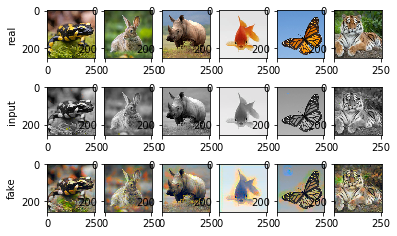

[0.5988825559616089, 0.9505571722984314, 0.9430291652679443, 1.504800796508789, 1.0255340337753296, 0.7472513318061829]


In [52]:
# Mark Please don't hate me but I'm going back to the giant list of variables

if __name__ == '__main__':
    # PARSER
    model = 'GAN'
    mode = 'evaluate'
    user = 'alice'
    img_path = 'five_categories/'
    val_path = 'five_categories_val/'
    test_path = 'five_categories_test/'
    in_prefix = None
    out_prefix = 'five_categories'
    num_imgs = 2000
    val_num_imgs = 450 
    test_num_imgs = 50
    batch_size = 100
    epochs = 5

    if torch.cuda.is_available():
        torch.set_default_tensor_type(torch.cuda.FloatTensor)
    np.random.seed(42)
    torch.manual_seed(42)

    # OTHER HYPERPARAMETERS
    P = {'g_hidden_size1': 32, 'g_hidden_size2': 64, 'g_hidden_size3':128, 'g_hidden_size4':256, 'd_input_size':64, 'd_kernel_size':5, 'd_kernel_number':64, 'd_hidden_size':64,
         'd_output_size':1, 'd_conv_layers':3, 'd_fclayers':2}

    if user=='mark':
        source_path = '/content/drive/My Drive/ECE324 Project/'
    elif user=='alice':
        source_path = '/content/drive/My Drive/ECE324 Project/'

    
    if mode != 'inference':
        images = import_folder(source_path+img_path, num_imgs).float()
        grayimages = process(images.cpu())
        if torch.cuda.is_available():
            grayimages.cuda()
            images.cuda()
        DT = TensorDataset(grayimages, images)
        train_loader = DataLoader(DT, batch_size=batch_size, shuffle=True)
        train_size = len(images)
        images = import_folder(source_path+val_path, val_num_imgs).float()
        grayimages = process(images.cpu())
        if torch.cuda.is_available():
            grayimages.cuda()
            images.cuda()
        DT = TensorDataset(grayimages, images)
        val_loader = DataLoader(DT, batch_size=batch_size, shuffle=True)
        images = import_folder(source_path+test_path, test_num_imgs).float()
        grayimages = process(images.cpu())
        if torch.cuda.is_available():
            grayimages.cuda()
            images.cuda()
        DT = TensorDataset(grayimages, images)
        test_loader = DataLoader(DT, batch_size=batch_size, shuffle=True)


    # CALL RUN IF INFERENCE MODE
    if mode == 'evaluate':
        source = '/content/drive/My Drive/ECE324 Project/Eval Images/new images/Large/'
        evaluate('/content/drive/My Drive/ECE324 Project/Five Categories Resnet Model/five_categories_G.pt', source, 6, source, size='Large')
    elif mode == 'inference':
        images = import_folder('/content/drive/My Drive/ECE324 Project/Test_images/Small/', 3, expected_size=(64, 64, 3)).float()
        grayimages = process(images)
        DT = TensorDataset(grayimages, images)
        data = DataLoader(DT, batch_size=3, shuffle=False)
        model=torch.load('/content/drive/My Drive/ECE324 Project/five_categories_G.pt')
        run(model, data, '/content/drive/My Drive/ECE324 Project/Test_images/Large/final_model_new_small.png')

    elif mode == 'inference2':
        images = import_folder('/content/drive/My Drive/ECE324 Project/five_categories_test/', 4, expected_size=(64, 64, 3)).float()
        grayimages = process(images)
        DT = TensorDataset(grayimages, images)
        data = DataLoader(DT, batch_size=4, shuffle=False)
        model=torch.load('/content/drive/My Drive/ECE324 Project/Five Categories Resnet Model/five_categories_G.pt')
        run(model, data, '/content/drive/My Drive/ECE324 Project/interm_model.png')

    # CALL EITHER MODEL
    else:
        if model == "GAN":
            G = None
            D = None
            PT = True if in_prefix==None else False

            if in_prefix == None:
                G = GenResNet(hidden_size1=P['g_hidden_size1'], hidden_size2=P['g_hidden_size2'], hidden_size3=P['g_hidden_size3'], hidden_size4=P['g_hidden_size4'])
                D = Discriminator(input_size=P['d_input_size'], kernelSize=P['d_kernel_size'], kernelNum=P['d_kernel_number'],
                                  hidden_size=P['d_hidden_size'], output_size=P['d_output_size'], convlayers=P['d_conv_layers'],
                                  fclayers=P['d_fclayers'])
            else:
                try:
                    G = torch.load(source_path+in_prefix + '_G.pt')
                    D = torch.load(source_path+in_prefix + '_D.pt')
                except:
                    print("MODELS NOT FOUND")
                    exit()

            if torch.cuda.is_available():
                G.cuda()
                D.cuda()
            
            train_GAN(G, D, train_loader, val_loader, test_loader, num_imgs, val_num_imgs, test_num_imgs, source_path, pretraining=PT, out_file=out_prefix, num_epochs=epochs, d_learning_rate=0.004, g_learning_rate=0.001, m_param=P)
        elif model=='baseline':
            M = None

            if in_prefix == None:
                M = Autoencoder()

            else:
                try:
                    M = torch.load(source_path+in_prefix + '_B.pt')
                except:
                    print("MODEL NOT FOUND")
                    exit()

            if torch.cuda.is_available():
                M.cuda()

            train_baseline(M, train_loader, val_loader, test_loader, num_imgs, val_num_imgs, test_num_imgs, source_path, num_epochs=epochs)